# quant sandbox: *Food Fight!*
This notebook lets me play around with quantitative analysis of Altru output. Currently set up to take two files, one with program data and another with attendee data, and customized for the Food Fight program series.

In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

In [113]:
def convert_yesno_to_bool(yesno):
    """ This method converts 'yes' and 'no' in an Altru excel file to boolean values."""
    if yesno.casefold() == "yes".casefold():
        return True
    elif yesno.casefold() == "no".casefold():
        return False
    else:
        return np.nan

In [114]:
def clean_up_df(raw_df):
    """ 
    This method takes a dataframe with program information like Name, Location, Date, Time, Capacity, 
    and two rows for Attended, one with a number for 'Yes' and another with a number for 'No'
    """
    clean_df = pd.DataFrame(columns=('Name', 'Type', 'Location', 'Date', 'Time', 'Day', 
                                     'Capacity', 'Preregistered', 'Attended', 'Percentage'))
    clean_df['Name'] = raw_df['Name'].unique()
    
    for i in range(len(clean_df)):
        namemask = raw_df.where(raw_df['Name'] == clean_df['Name'][i])
        fvi = namemask.first_valid_index()
        clean_df['Location'][i] = namemask['Location'][fvi]
        clean_df['Date'][i] = pd.to_datetime(namemask['Date'][fvi])
        clean_df['Time'][i] = namemask['Time'][fvi]
        clean_df['Capacity'][i] = namemask['Capacity'][fvi]
        yes_fvi = namemask.where(namemask['Attended'] == "Yes").first_valid_index()
        if yes_fvi == None:
            clean_df['Attended'][i] = 0
        else:
            clean_df['Attended'][i] = namemask['Number'][yes_fvi]
        no_fvi = namemask.where(namemask['Attended'] == "No").first_valid_index()
        if no_fvi == None:
            clean_df['Preregistered'][i] = clean_df['Attended'][i]
        else:
            clean_df['Preregistered'][i] = clean_df['Attended'][i] + namemask['Number'][no_fvi]
                                                                                    
    clean_df['Percentage'] = clean_df['Attended'] / clean_df['Preregistered']
    clean_df.sort_values(by="Date", inplace=True)
    clean_df['Day'] = [j.strftime('%a') for j in clean_df['Date']]

    return clean_df

In [115]:
raw_program_data = pd.read_excel("~/Documents/attendance_data/foodfight_program_data.xlsx", engine='openpyxl')

In [116]:
programs = clean_up_df(raw_program_data)
print(programs.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 7 to 9
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Name           22 non-null     object
 1   Type           0 non-null      object
 2   Location       22 non-null     object
 3   Date           22 non-null     object
 4   Time           22 non-null     object
 5   Day            22 non-null     object
 6   Capacity       22 non-null     object
 7   Preregistered  22 non-null     object
 8   Attended       22 non-null     object
 9   Percentage     22 non-null     object
dtypes: object(10)
memory usage: 1.9+ KB
None


In [117]:
## Keywords to search for to allocate workshops, conversations, performances, and other not listed
workshops = ['workshop', 'ethnobotany', 'food landscape', 'farmers market']
conversations = ['intersection', 'conversation', 'discussion']
performances = ['screening', 'poetry slam', 'dancers and singers', 'performance']

for i in range(len(programs)):
    for keyword in workshops:
        if keyword.casefold() in programs['Name'][i].casefold():
            programs['Type'][i] = "Workshop"
    for keyword in conversations:
        if keyword.casefold() in programs['Name'][i].casefold():
            programs['Type'][i] = "Conversation"
    for keyword in performances:
        if keyword.casefold() in programs['Name'][i].casefold():
            programs['Type'][i] = "Performance"
    if "cancelled".casefold() in programs['Name'][i].casefold():
        programs['Type'][i] = "Other"
    elif "postponed".casefold() in programs['Name'][i].casefold():
        programs['Type'][i] = "Other"
#     w_idx = programs['Name'].str.casefold().str.contains("workshop".casefold())
#     programs['Type'][w_idx] = "Workshop"
nan_idx = programs['Type'].isnull()
programs['Type'][nan_idx] = 'Other'
programs['Location'] = programs['Location'].replace("Beal Botanical Garden", "Beal")
# programs['Location'] = programs['Location'].replace("STEM Teaching and Learning Facility", "STEM")
# print(programs['Type'])

In [118]:
loc_cats = programs['Location'].value_counts().unique()
programs['Location'] = pd.Categorical(programs['Location'], categories=loc_cats, ordered=True)

In [119]:
type_cats = ['Workshop', 'Conversation', 'Performance', 'Other']
programs['Type'] = pd.Categorical(programs['Type'], categories=type_cats, ordered=True)

<Axes: xlabel='Date', ylabel='Percentage'>

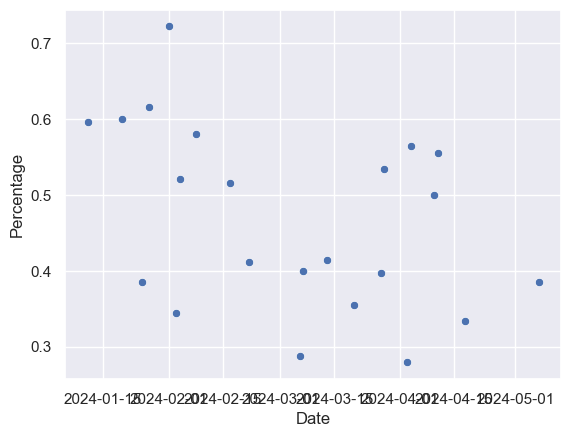

In [120]:
sns.scatterplot(data=programs, x='Date', y='Percentage')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='Location', ylabel='Percentage'>

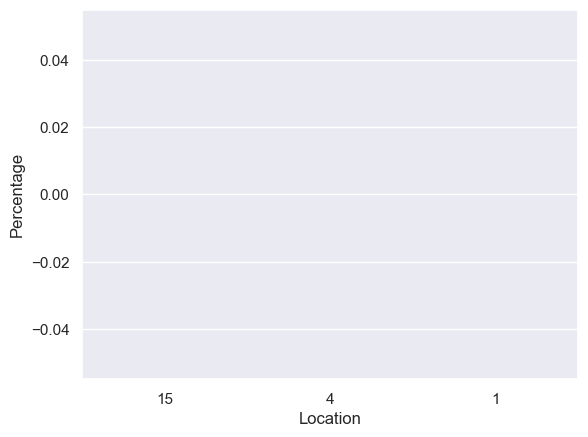

In [121]:
sns.barplot(data=programs, x='Location', y='Percentage', saturation=1, alpha=0.75)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='Type', ylabel='Percentage'>

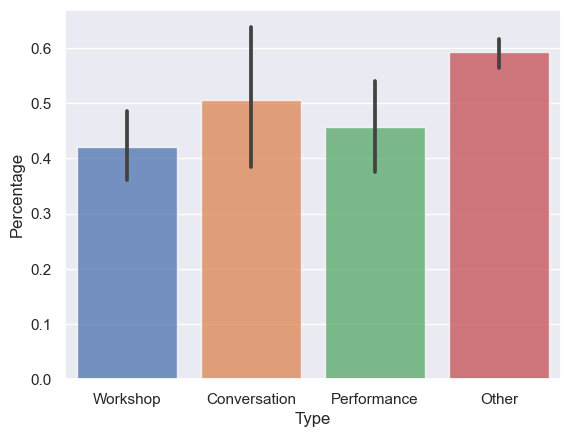

In [122]:
sns.barplot(data=programs.sort_values('Type'), x='Type', y='Percentage', saturation=1, alpha=0.75)

<Axes: xlabel='Time', ylabel='Percentage'>

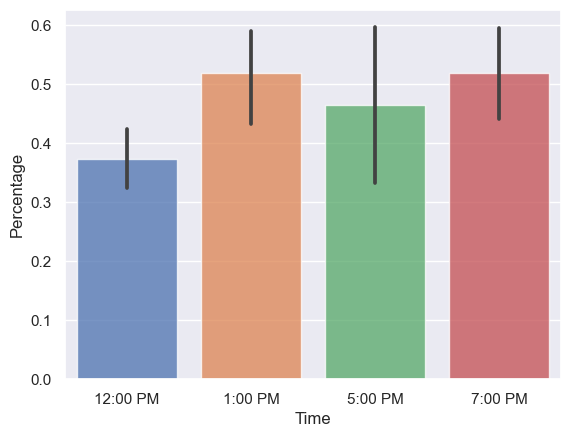

In [123]:
sns.barplot(data=programs.sort_values('Time'), x='Time', y='Percentage', saturation=1, alpha=0.75)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


[Text(0.5, 0, 'Day of the week'),
 Text(0, 0.5, 'Percentage'),
 Text(0.5, 1.0, 'Attendance by day of the week')]

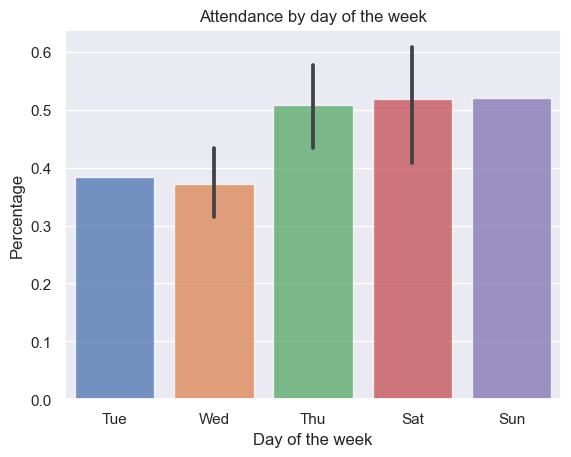

In [124]:
days = ['Tue', 'Wed', 'Thu', 'Sat', 'Sun']
programs['Day'] = pd.Categorical(programs['Day'], categories=days, ordered=True)
graph = sns.barplot(data=programs.sort_values('Day'), x='Day', y='Percentage', saturation=1, alpha=0.75)
graph.set(xlabel="Day of the week", ylabel="Percentage", title='Attendance by day of the week')

In [125]:
registrants = pd.read_excel("~/Documents/attendance_data/altru_foodfight_program_attendees.xlsx", engine='openpyxl', 
                            converters={'Attended': convert_yesno_to_bool})
registrants.rename(columns={"Name": "Visitor name",
                          "Registration Information\\Response": "MSU affiliation", 
                          "Program Events\\Name": "Program name", 
                          "Program Events\Capacity": "Program capacity",
                          "Program Events\\Locations\\Name": "Program location"},
                   inplace=True)
display(registrants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1931 entries, 0 to 1930
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Visitor name      1931 non-null   object
 1   Attended          1931 non-null   bool  
 2   Host name         1119 non-null   object
 3   MSU affiliation   1325 non-null   object
 4   Program name      1931 non-null   object
 5   Program capacity  1931 non-null   int64 
 6   Program location  1931 non-null   object
 7   QUERYRECID        1931 non-null   object
dtypes: bool(1), int64(1), object(6)
memory usage: 107.6+ KB


None

In [126]:
sum(registrants['MSU affiliation'].notnull())
# count = df[df['City'] == 'New York']['Age'].notnull().sum()

1325

In [127]:
affils = pd.DataFrame(columns=('MSU affiliation', 'Attended', 'Preregistered', 'Percentage'))
affils['MSU affiliation'] = ['Student', 'Faculty or Staff', 'Alum', 'Parent/Family', 'Not MSU', 'N/A']

for item in affils['MSU affiliation'][0:-1]:
    affils['Attended'][affils['MSU affiliation'] == item] = sum(registrants['MSU affiliation'][registrants['Attended']] == item)
    affils['Preregistered'][affils['MSU affiliation'] == item] = sum(registrants['MSU affiliation'] == item)
    
affils['Attended'][affils['MSU affiliation'] == 'N/A'] = len(registrants['MSU affiliation'][registrants['Attended']]) - sum(registrants['MSU affiliation'][registrants['Attended']].notnull())
affils['Preregistered'][affils['MSU affiliation'] == 'N/A'] = len(registrants['MSU affiliation']) - sum(registrants['MSU affiliation'].notnull())
affils['Percentage'] = affils['Attended'] / affils['Preregistered']
display(affils)

,MSU affiliation,Attended,Preregistered,Percentage
0,Student,223,356,0.626404
1,Faculty or Staff,168,322,0.521739
2,Alum,85,204,0.416667
3,Parent/Family,47,110,0.427273
4,Not MSU,108,333,0.324324
5,N/A,276,606,0.455446


[Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of people'),
 Text(0.5, 1.0, 'Program preregistration by MSU affiliation')]

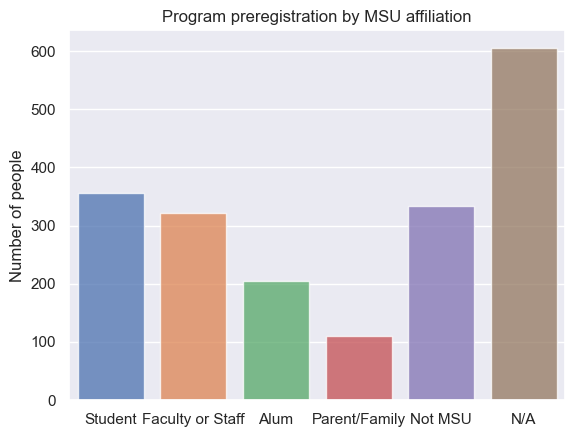

In [128]:
graph = sns.barplot(data=affils, x='MSU affiliation', y='Preregistered', saturation=1, alpha=0.75)
graph.set(xlabel="", ylabel="Number of people", title='Program preregistration by MSU affiliation')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Percentage'),
 Text(0.5, 1.0, 'Attendance percentage by MSU affiliation')]

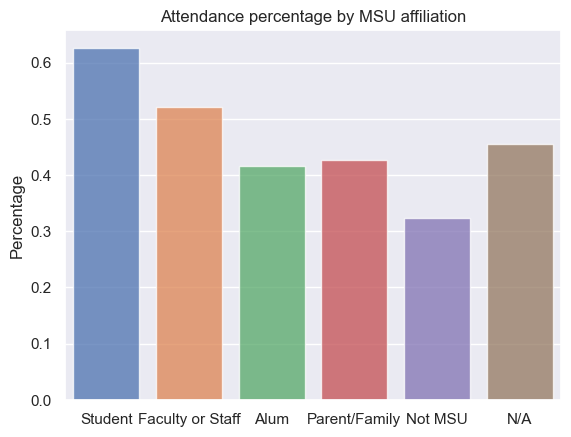

In [129]:
graph = sns.barplot(data=affils, x='MSU affiliation', y='Percentage', saturation=1, alpha=0.75)
graph.set(xlabel="", ylabel="Percentage", title='Attendance percentage by MSU affiliation')